In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as pltA
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
T = 10.0
N = 300#1000 PCスペックの都合で変更
eta = T/N

In [3]:
@jax.jit
def Euler(p):
    x = jnp.ones(2)
    x_trj = jnp.zeros(N)
    y_trj = jnp.zeros(N)
    for i in range(N):
        x = x.at[0].set(x[0] + (p[0] * x[0] - p[1]*x[0]*x[1]) * eta)
        x = x.at[1].set(x[1] + (-p[2] * x[1] + p[3]*x[0]*x[1]) * eta)
        x_trj = x_trj.at[i].set(x[0])
        y_trj = y_trj.at[i].set(x[1])
    return x_trj, y_trj

In [4]:
p = jnp.array([1.5, 1., 3., 1.])
x, y = Euler(p)

In [5]:
df = pd.DataFrame()
df["t"] = jnp.arange(0, T, eta)
df["x_initial"] = x
df["y_initial"] = y

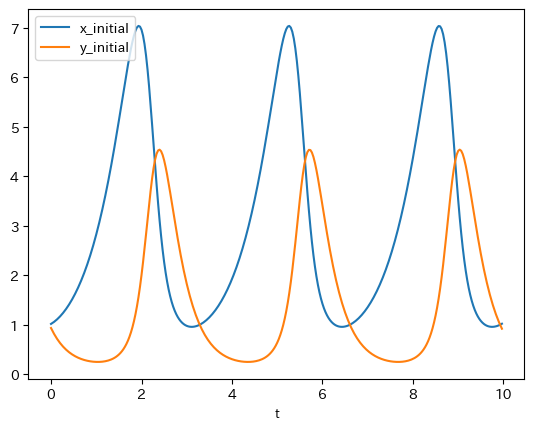

In [7]:
df.plot(x = "t", y = df.columns[1:]);

In [8]:
# @jax.jit
def DU_Euler(params):
    x = jnp.ones(2)
    loss = 0.
    for i in range(N):
        x += eta * (jnp.array([params[0], params[2]])*x + jnp.array([params[1], params[3]])*jnp.prod(x))
        loss += JLA.norm(x - jnp.ones(2))**2
    return loss

In [9]:
adam_lr = 1e-1
train_itr = 50

opt_init, opt_update, get_params = optimizers.adam(adam_lr)

def train(prams):
    opt_state = opt_init(prams)
    for i in trange(train_itr):
        value, grads = jax.value_and_grad(DU_Euler, argnums=-1)(get_params(opt_state))
        opt_state = opt_update(i, grads, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    tmp = get_params(opt_state)
    return jnp.array([tmp[0], -tmp[2], -tmp[1], tmp[3]])

In [10]:
p = jnp.array([1.5, 1.0, 3.0, 1.0])
p_alpha_delta = jnp.array([p[0], -p[2]])
p_beta_gamma = jnp.array([-p[1], p[3]])
prams = jnp.concat([p_alpha_delta, p_beta_gamma])

In [11]:
p_trained = train(prams)

  0%|          | 0/50 [00:00<?, ?it/s]

loss:0.46376723051071167 

In [15]:
x, y = Euler(p_trained)

In [16]:
df["x_trained"] = x
df["y_trained"] = y

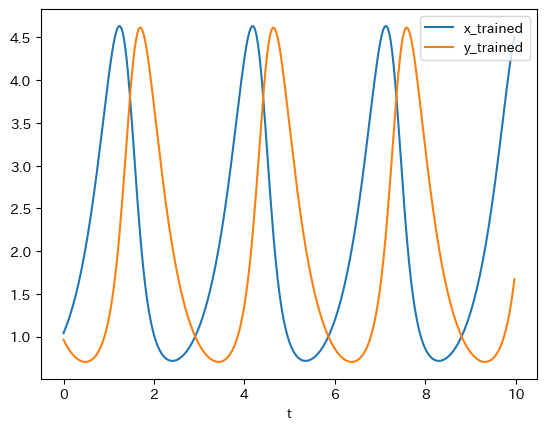

In [17]:
df.plot(x = "t", y =["x_trained", "y_trained"]);